# Demo de Deep Autoencoder (DAE) para procesar las imágenes de algunos TIPOS de ANIMALES
Basado en: 

https://blog.keras.io/building-autoencoders-in-keras.html


https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3

1) Importar librerías:

In [1]:
# nota se debe indicar la versión 1 de TF para compatibilidad del código
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

print("\nLibrerías importadas")

TensorFlow 1.x selected.
1.15.2


Using TensorFlow backend.



Librerías importadas


2) Definir la configuración del modelo DAE:

In [16]:
# tamaño de las imágenes 
# por compatibilidad de tipo de imágenes, para ANIMALES usar sólo en blanco y negro: 1 canal
IMAGE_SHAPE = (28, 28, 3)

# cantidad de neuronas ocultas para features (datos comprimidos o codings)
num_features = 12

# cantidad de neuronas ocultas para la parte Encoder 
#   (cada elemento de la lista es la cantidad de pesos que tiene cada una)
dae_layers = [ 392, 196, 84, 56, 32 ] 

# define tamaño de datos de entrada y salida
num_inputs = IMAGE_SHAPE[0] * IMAGE_SHAPE[1] * IMAGE_SHAPE[2]
num_outputs = num_inputs

#  agrega la capa de features a las capas
dae_layers.append( num_features ) 

# cantidad de neuronas ocultas para la parte Decoder 
#   (usa la la lista de Encoder inversa)
for eachEncLayer in dae_layers[0:len(dae_layers)-1][::-1]:
  dae_layers.append( eachEncLayer )

# cantidad de épocas del entrenamiento
# (a medida que la cantidad de capas ocultas se mayor y el nro de features es menor, 
#   se recomienda entrenar más épocas)
cantEpocas = 500

print("Configuración del DAE definida: [", num_inputs, dae_layers, num_outputs, "] ")

Configuración del DAE definida: [ 2352 [392, 196, 84, 56, 32, 12, 32, 56, 84, 196, 392] 2352 ] 


3) Montar el Drive:

In [17]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demo ANIMALES' 
imagPath = path + '/imagenes/train' 

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo DAE:

In [18]:
# cargar las imágenes
classes_ori = [] 
images_ori = []

all_dirs = os.listdir( imagPath )
for each_dir in all_dirs:

    auxiPath = imagPath + '/' + each_dir 
    imagFN  = os.listdir( auxiPath )
    for each_imagFN in imagFN:
          
          # abre la imagen
          imag = Image.open(auxiPath + "/" + each_imagFN)
          
          # ajusta el tamaño
          if IMAGE_SHAPE[2]==1:        
            tipoImage = 'L'
          else:                
            tipoImage = 'RGB'
          imag = imag.convert(tipoImage)
          imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
          
          # transforma a un vector de nros
          arImag = np.array(imag)
          
          # agrega a los vectores
          classes_ori.append( each_dir )
          images_ori.append( arImag )

print("- Clases cargadas: ", len(classes_ori))
print("- Imágenes cargadas: ", len(images_ori))

if len(images_ori)>0:
  print("\n- Ejemplo ", classes_ori[0], " ", images_ori[0].shape, ": ")
  display( Image.fromarray(images_ori[0], tipoImage) )

- Clases cargadas:  42
- Imágenes cargadas:  42

- Ejemplo  invertebrado   (28, 28, 3) : 


x_train (cant ejemplos, datos entrada):  (42, 2352)

Imagen reconstruida: 


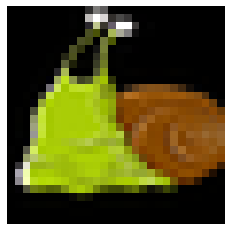

In [19]:
# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8))
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), num_inputs))  
  return auxiAr

# define vector auxiliar para usar en el entrenamiento
x_train = prepare_imageList(images_ori)

print("x_train (cant ejemplos, datos entrada): ", x_train.shape)
print("\nImagen reconstruida: ")
plot_image(x_train[0])

5) Creación del modelo DAE:

Modelo DAE creado con  13  capas:
Model: "DAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 2352)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 392)               922376    
_________________________________________________________________
enc_2 (Dense)                (None, 196)               77028     
_________________________________________________________________
enc_3 (Dense)                (None, 84)                16548     
_________________________________________________________________
enc_4 (Dense)                (None, 56)                4760      
_________________________________________________________________
enc_5 (Dense)                (None, 32)                1824      
_________________________________________________________________
features (Dense)             

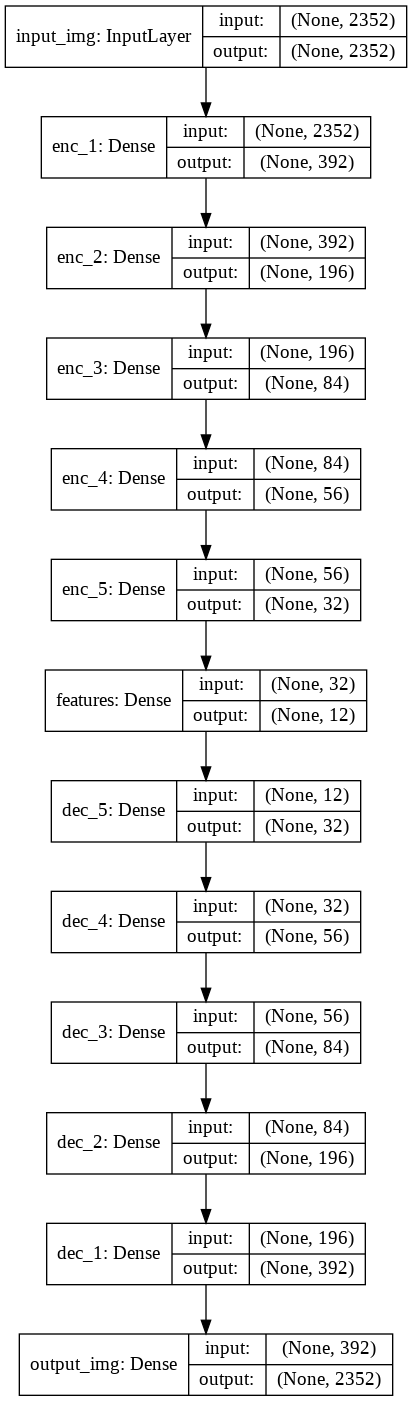

In [20]:
# define la arquitectura de capas del Deep Autoencoder
# teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'enc_'
auxId = 1 
for num_hid in dae_layers:  

    # define el nombre de la capa oculta
    if num_features==num_hid:
        auxlayerName = 'features'
        auxName = 'dec_'
        auxId = auxId - 1
    else:
        auxlayerName = auxName+str(auxId)
        if auxName == 'enc_':
          auxId = auxId + 1
        else:
          auxId = auxId - 1

    # agrega la capa oculta
    eachLay = Dense(num_hid, activation='relu', name=auxlayerName)(eachLay) # capas ocultas

    if num_features==num_hid:
      features_Lay = eachLay

output_img_Lay = Dense(num_outputs, activation=None, name='output_img')(eachLay) # capa de salida

# genera el modelo Deep Autoencoder
DAEmodel = Model(input_img_Lay, output_img_Lay, name='DAE')
DAEmodel.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print("Modelo DAE creado con ", len(DAEmodel.layers), " capas:")
DAEmodel.summary()
print("\n")
plot_model(DAEmodel, show_layer_names=True, show_shapes=True)

5) Entrenar el modelo DAE:

In [21]:
# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
DAEmodel.fit(x_train, x_train,
                epochs = cantEpocas, #100,
                batch_size = 5)

Epoch 1/500
42/42 [==============================] - 0s 6ms/step - loss: 0.1133 - accuracy: 0.0000e+00
Epoch 2/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0502 - accuracy: 0.0000e+00
Epoch 3/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0507 - accuracy: 0.0000e+00
Epoch 4/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.0000e+00
Epoch 5/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0526 - accuracy: 0.0000e+00
Epoch 6/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0494 - accuracy: 0.0000e+00
Epoch 7/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0528 - accuracy: 0.0000e+00
Epoch 8/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0491 - accuracy: 0.0000e+00
Epoch 9/500
42/42 [==============================] - 0s 1ms/step - loss: 0.0529 - accuracy: 0.0000e+00
Epoch 10/500
42/42 [==============================] - 0s 1ms/step - loss:

7) Evaluar el modelo DAE entrenado solicitando que reconstruya las imágenes ingresadas:

42/42 [==============================] - 0s 1ms/step

>Evaluación del Modelo: 
    - Error:  0.00047161193825082765
    - Exactitud:  14.28571492433548



>Resultados: 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


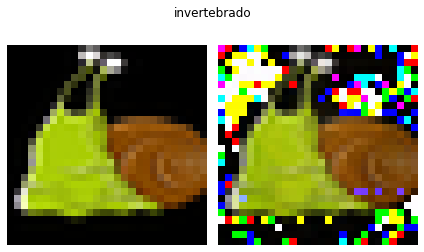

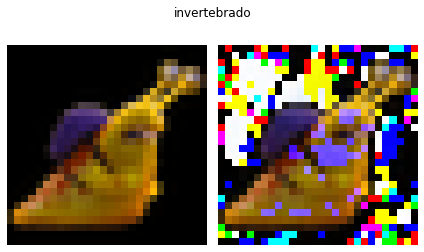

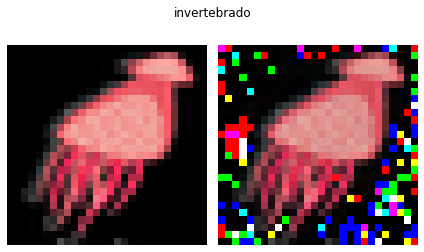

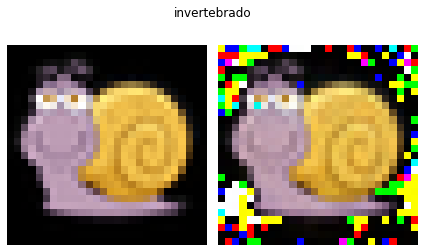

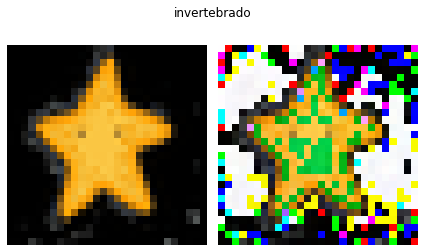

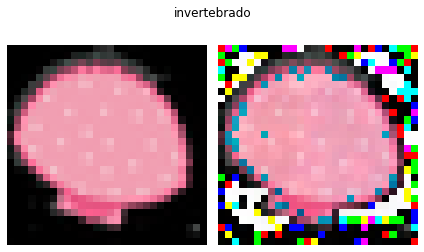

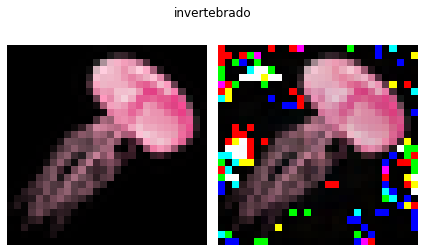

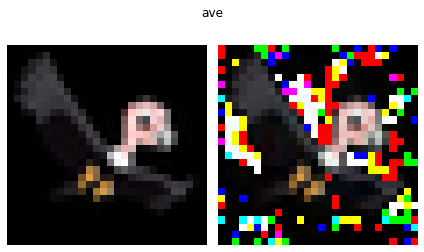

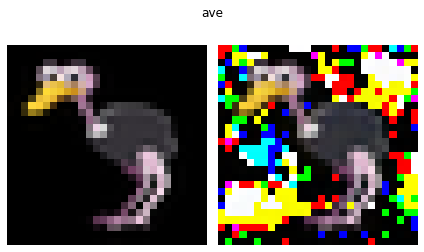

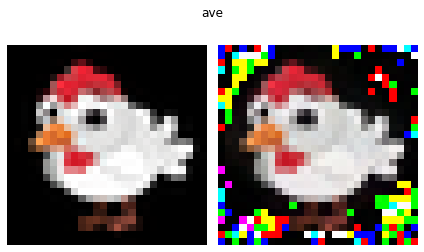

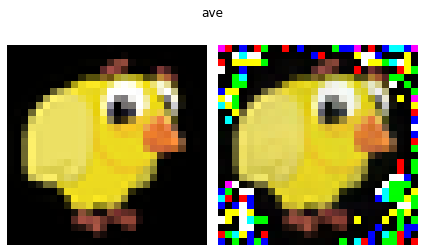

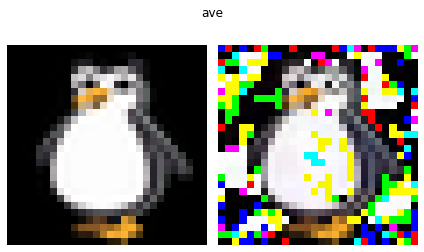

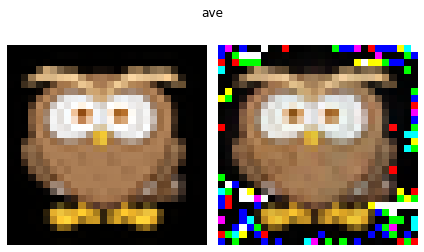

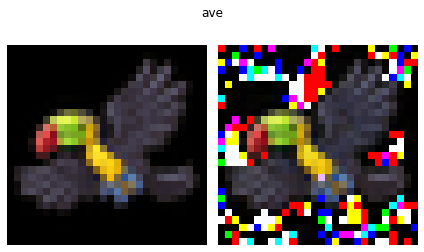

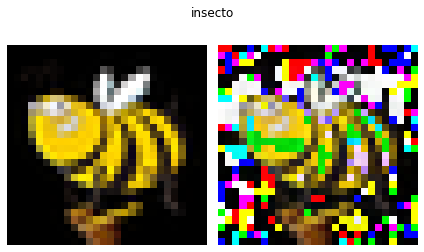

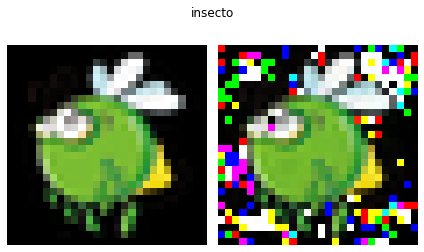

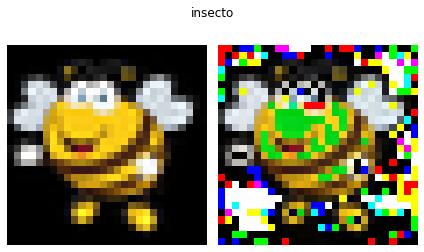

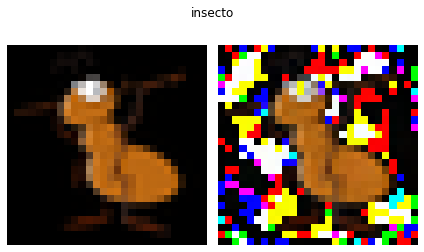

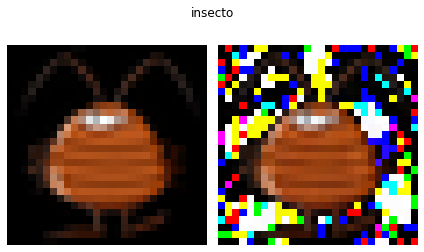

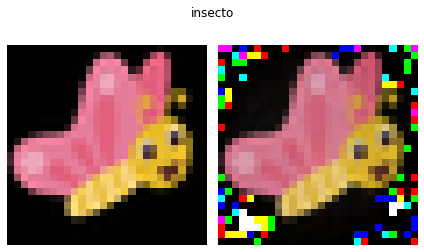

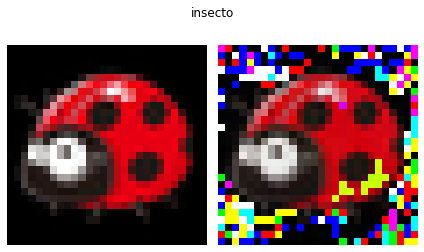

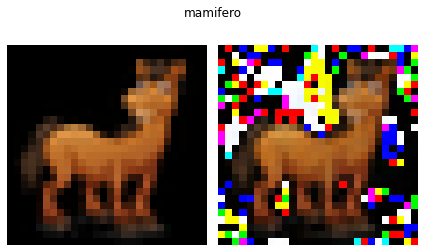

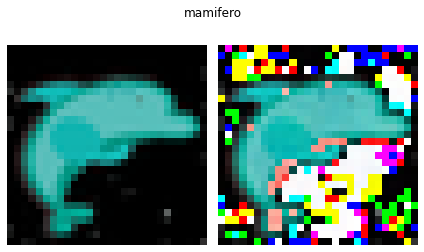

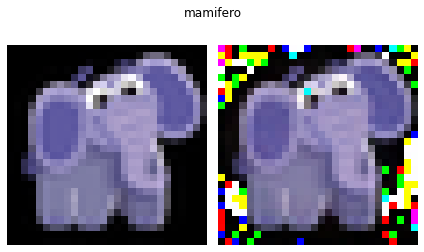

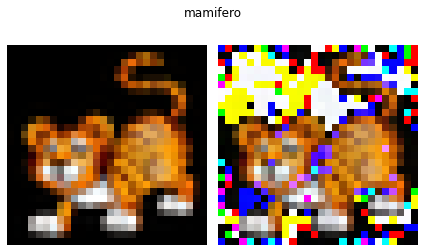

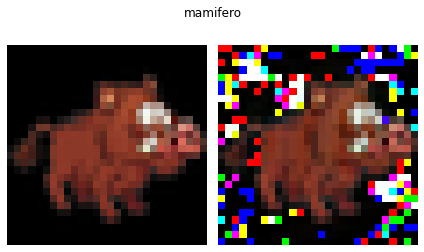

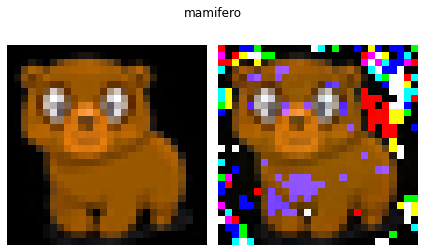

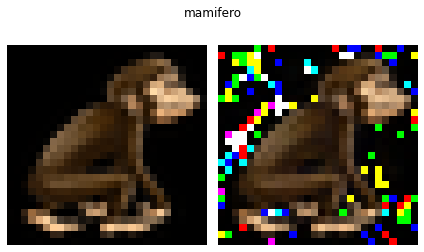

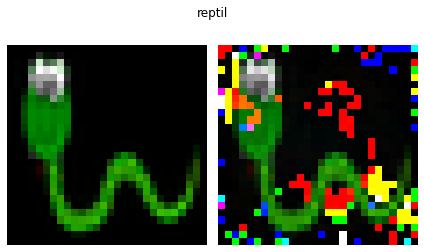

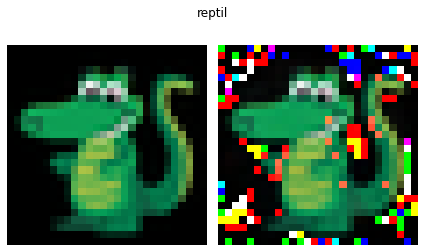

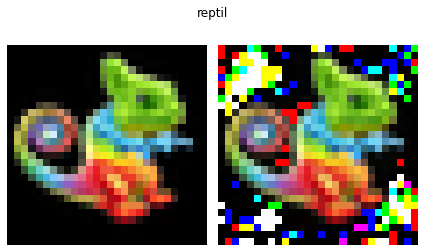

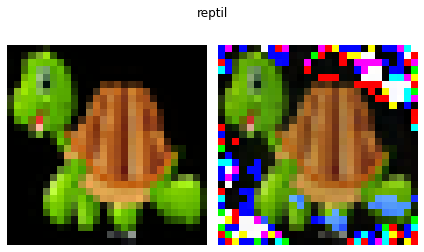

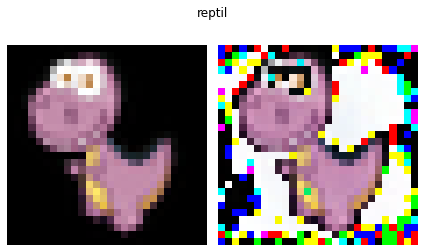

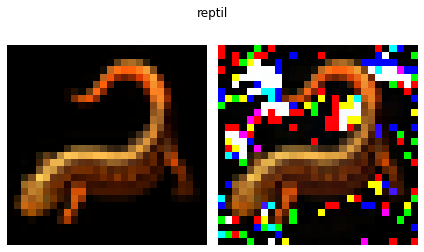

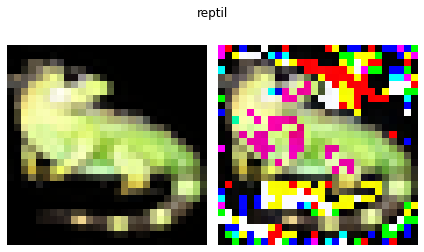

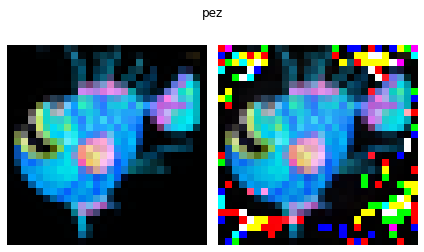

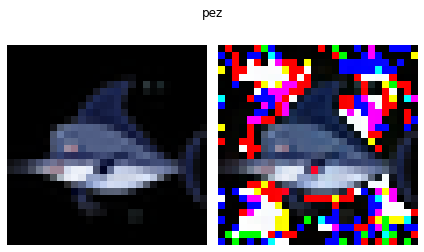

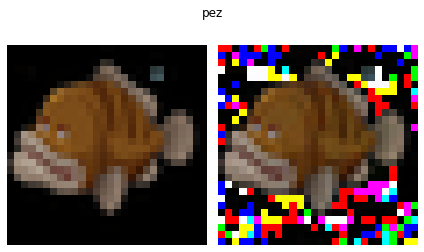

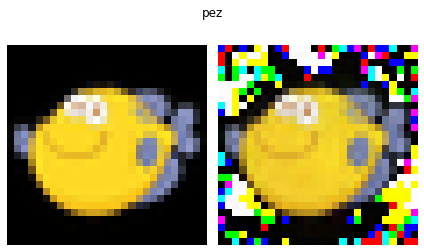

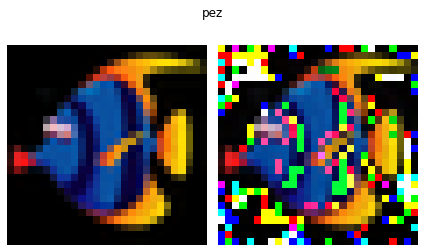

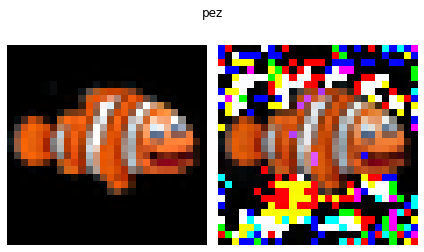

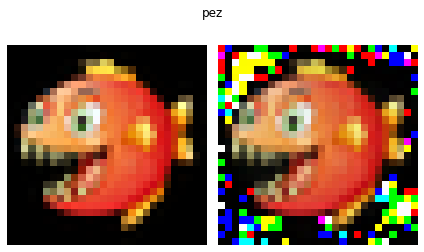

In [22]:
# evalua al modelo 
resEval = DAEmodel.evaluate(x_train, x_train)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# procesa las imágenes con el modelo 
reconstr_imgs = DAEmodel.predict(x_train)

# muestra las 15 primeras imágenes 
print("\n>Resultados: ")
for i in range(len(x_train)):

    # prepara para mostrar
    fig = plt.figure()
    fig.suptitle(classes_ori[i])

    # muestra la real
    ax1 = fig.add_subplot(121)
    plot_image(x_train[i])

    # muestra la generada por el modelo
    ax2 = fig.add_subplot(122)
    plot_image(reconstr_imgs[i])

    plt.tight_layout()
    fig = plt.gcf()


9) Probar el modelo DAE entrenado con otras imágenes:

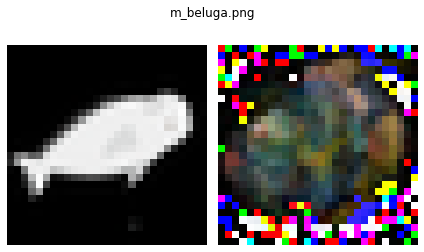

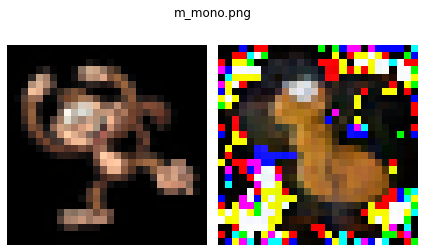

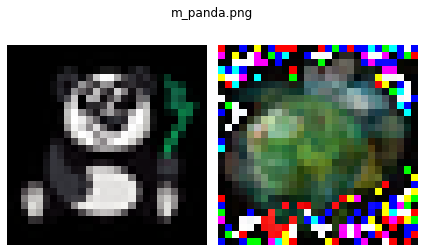

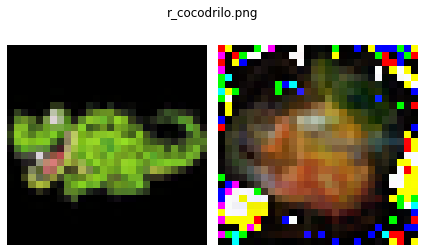

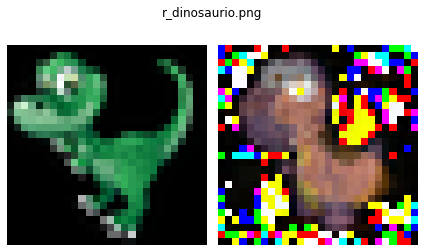

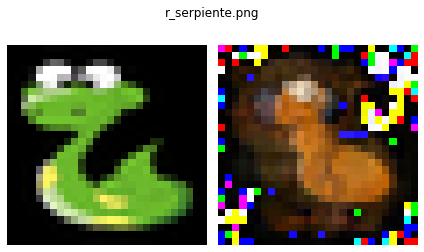

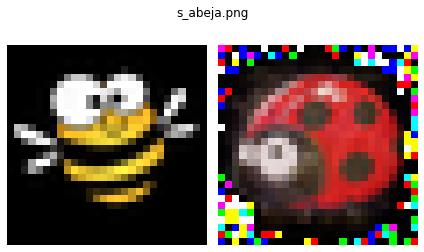

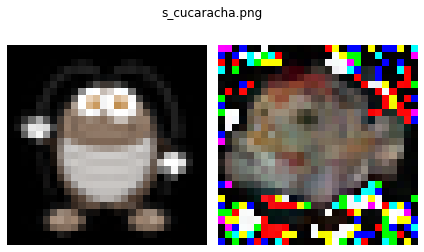

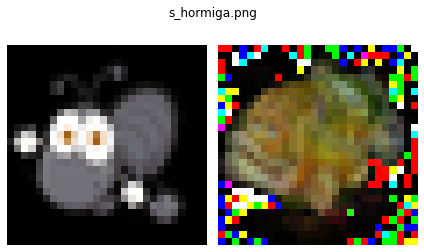

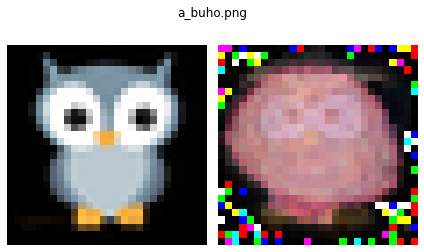

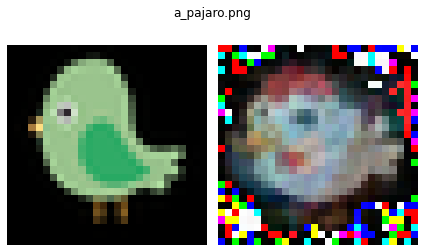

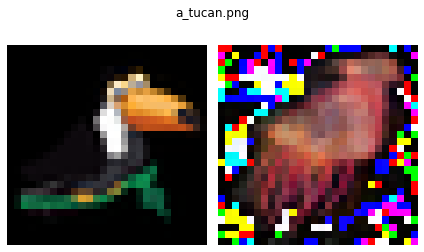

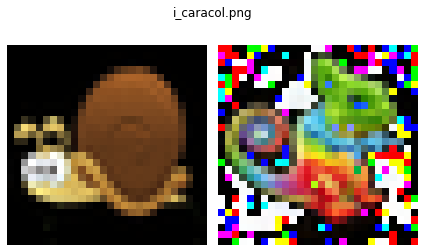

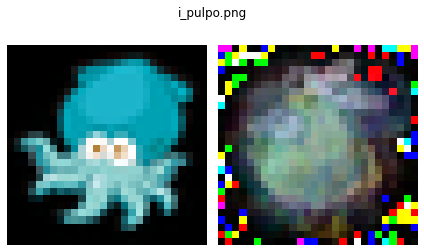

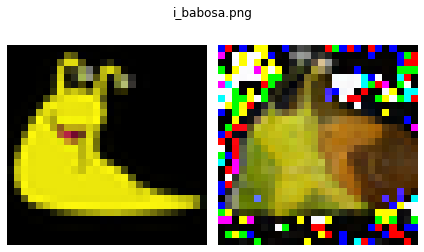

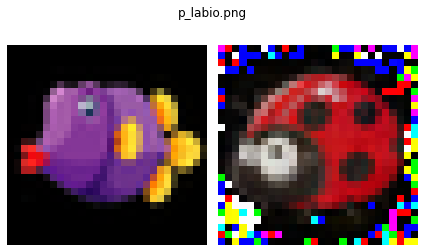

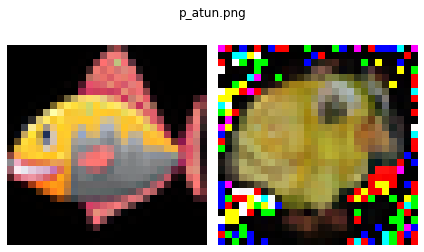

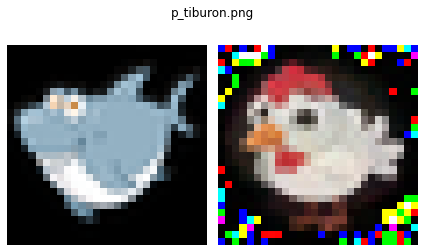

In [25]:
# función auxiliar para reconstruir la imagen
def reconstruct_image(imag, imagClase):
    
    # prepara y ajusta el tamaño de la imagen
    imagPrep = prepare_imageList([imag])
    
    # ejecuta el modelo
    imagOut = DAEmodel.predict(imagPrep)
    
    # prepara para mostrar
    fig = plt.figure()
    fig.suptitle(imagClase)

    # muestra la real
    ax1 = fig.add_subplot(121)
    plot_image(imagPrep)

    # muestra la generada por el modelo
    ax2 = fig.add_subplot(122)
    plot_image(imagOut)

    plt.tight_layout()
    fig = plt.gcf()


# carga las imágenes de prueba
imagPathPrueba = path + '/imagenes/test' 
all_dirs =  os.listdir( imagPathPrueba ) 
for each_dir in all_dirs:

    auxiPath = imagPathPrueba + '/' + each_dir 
    if os.path.isdir(auxiPath):
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:
          
          # abre la imagen
          imag = Image.open(auxiPath + "/" + each_imagFN)
          
          # ajusta el tamaño
          if IMAGE_SHAPE[2]==1:        
            tipoImage = 'L'
          else:                
            tipoImage = 'RGB'
          imag = imag.convert(tipoImage)
          imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
          
          # transforma a un vector de nros
          arImag = np.array(imag)

          # manda a procesar la imagen cargada
          reconstruct_image(arImag, each_imagFN)
                  

8) A partir del modelo DAE entrenado, generar dos sub-modelos Encoder y Decoder:


*   Generar y usar el modelo Encoder para 'clusterizar' las imágenes de entrenamiento:


> Modelo Encoder: 
Model: "Encoder/Clustering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 2352)              0         
_________________________________________________________________
enc_1 (Dense)                (None, 392)               922376    
_________________________________________________________________
enc_2 (Dense)                (None, 196)               77028     
_________________________________________________________________
enc_3 (Dense)                (None, 84)                16548     
_________________________________________________________________
enc_4 (Dense)                (None, 56)                4760      
_________________________________________________________________
enc_5 (Dense)                (None, 32)                1824      
_________________________________________________________________
features (Dense)             

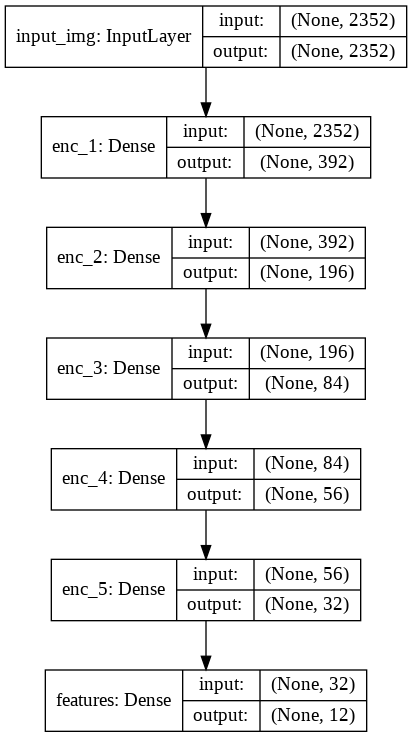

In [26]:
## Generar el sub-modelo Encoder para Clustering
## (desde input hasta features)

# reutiliza las capas entrenadas del modelo DAE original
clust_input_Lay = input_img_Lay  # capa de entrada
clust_output_Lay =  features_Lay  # capa de salida

# genera el modelo
CLUSTmodel = Model(input_img_Lay, features_Lay, name='Encoder/Clustering')

print("> Modelo Encoder: ")
CLUSTmodel.summary()
plot_model(CLUSTmodel, show_layer_names=True, show_shapes=True)



> Estadísticas de Clutering de Imágenes codificado en  12  valores: 
- Mínimos:    [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
- Máximos:    [0.         0.54516906 5.05023336 0.58359063 2.51455021 3.96846509
 3.36744475 1.60439062 0.14510331 1.36635435 3.94289207 0.        ]
- Totales:    [ 0.          0.64797612 65.33406408  0.8210713   8.69936599 35.44376868
 33.11009518  3.80650754  0.15983785  5.21490909 34.14551346  0.        ]
- Promedios:  [0.         0.015428   1.55557295 0.01954932 0.20712776 0.84389925
 0.7883356  0.09063113 0.00380566 0.1241645  0.81298842 0.        ]





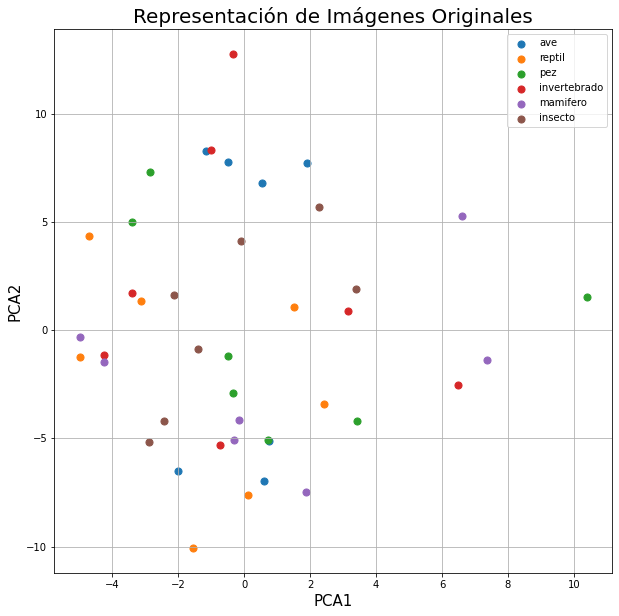

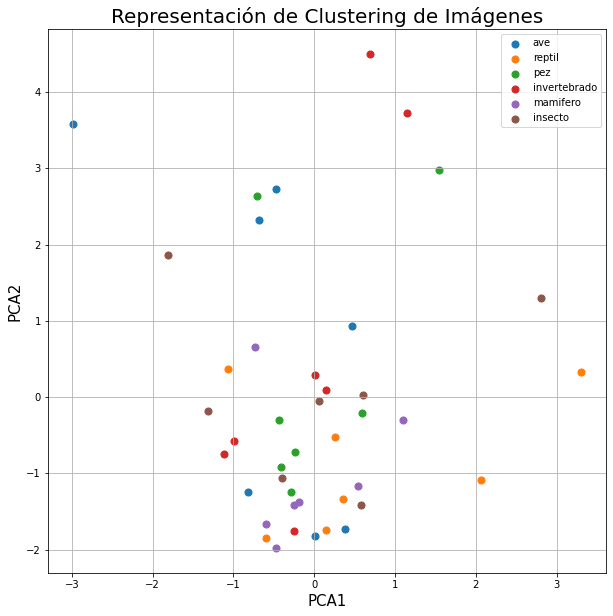

In [27]:
# función auxiliar para generar un gráfico 
# con los valores codificados 
# usando PCA para simplificarlos en 2 ejes
def genera_grafico_pca(datos, clases, titulo):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(datos)
    principalDf = pd.DataFrame(data = principalComponents,
                columns = ['pca_1', 'pca_2'])
    finalDf = pd.concat([principalDf, 
                        pd.DataFrame(clases, columns = ['target'])], 
                        axis = 1)

    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('PCA1', fontsize = 15)
    ax.set_ylabel('PCA2', fontsize = 15)
    ax.set_title(titulo, fontsize = 20)
    for target in set(classes_ori):
        indicesToKeep = finalDf['target'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'pca_2'],
                  finalDf.loc[indicesToKeep, 'pca_1'],
                  s = 50)
    ax.legend(set(classes_ori))
    ax.grid()

# procesa las imágenes para recibir el valor codificado de cada una
x_train_encoded = CLUSTmodel.predict(x_train)

# muestra el gráfico con imágenes originales
genera_grafico_pca(x_train, classes_ori, "Representación de Imágenes Originales")

# muestra estadísticas de los datos codificados
minArClust = np.empty(num_features)
minArClust.fill(9999.99)
maxArClust = np.empty(num_features)
maxArClust.fill(-9999.99)
sumArClust = np.zeros(num_features)
for val in x_train_encoded:
  for i in range(num_features):
      sumArClust[i] = sumArClust[i]+val[i]
      if val[i]<minArClust[i]: 
          minArClust[i] = val[i]
      if val[i]>maxArClust[i]: 
          maxArClust[i] = val[i]
print("\n\n> Estadísticas de Clutering de Imágenes codificado en ", num_features," valores: ")
print("- Mínimos:   ", minArClust)
print("- Máximos:   ", maxArClust)
print("- Totales:   ", sumArClust)
print("- Promedios: ", sumArClust/len(x_train_encoded))
print("\n\n")

# muestra el gráfico codificado
genera_grafico_pca(x_train_encoded, classes_ori, "Representación de Clustering de Imágenes")

*   Generar y usar el modelo Decoder para generar nuevas imágenes similares a las entrenadas:

> Modelo Decoder: 
Model: "Decoder/Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_gen (InputLayer)       (None, 12)                0         
_________________________________________________________________
dec_5 (Dense)                (None, 32)                416       
_________________________________________________________________
dec_4 (Dense)                (None, 56)                1848      
_________________________________________________________________
dec_3 (Dense)                (None, 84)                4788      
_________________________________________________________________
dec_2 (Dense)                (None, 196)               16660     
_________________________________________________________________
dec_1 (Dense)                (None, 392)               77224     
_________________________________________________________________
output_img (Dense)           (

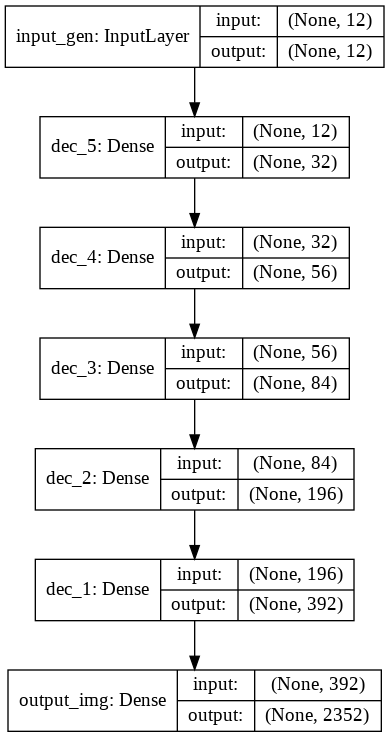

In [28]:
## Generar el sub-modelo Decoder para Generator
## (desde features hasta output)

# genera una copia del modelo DAE original para evitar romperlo
auxiCloneModel = keras.models.model_from_json(DAEmodel.to_json())
#auxiCloneModel.summary()

# genera la nueva estructura del Generator
input_gen = Input(shape=(num_features,), name='input_gen') # nueva capa de entrada
auxLay_gen = input_gen
for pos in range(len(DAEmodel.layers)):

  # obtiene el nombre de la capa actual
  auxName = DAEmodel.layers[pos].name  
  
  # sólo considera las capas luego de features (decoder y output)
  # para copiar los pesos del DAE original y actualizar la estrcutura
  if auxName.startswith('dec_') or auxName=='output_img':
    auxiCloneModel.layers[pos].set_weights(DAEmodel.layers[pos].get_weights()) 
    auxLay_gen = auxiCloneModel.layers[pos](auxLay_gen) 

# crea el nuevo modelo Generator
GENmodel = Model(input_gen, auxLay_gen, name = 'Decoder/Generator')

print("> Modelo Decoder: ")
GENmodel.summary()
plot_model(GENmodel, show_layer_names=True, show_shapes=True)

Genera usando estadísticas de Clustering

> Resultados: 


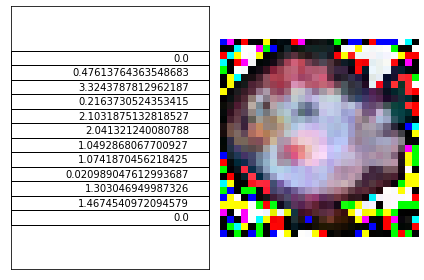

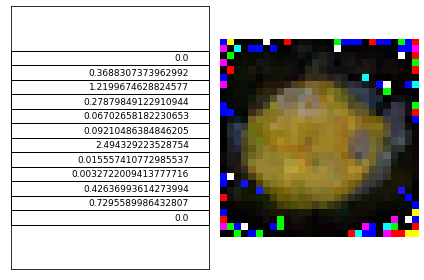

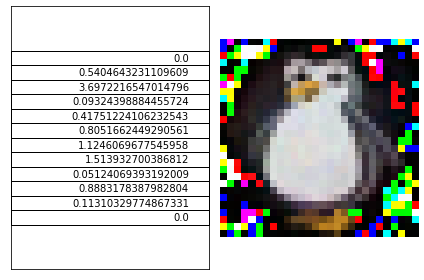

In [29]:
# ejecuta el Generator
#  usando valores definidos al azar como datos de entrada

cantImagenGenerar = 3
consideraEstadClust = True

# genera los datos de entrada
# (como la codificación tiene varias posiciones con ceros 
# se considera que sólo se ponen al azar entre 10% y el 70% de los valores, el resto queda en cero,
# --sino se podría hacer con " np.random.rand(cantImagenGenerar, num_features) "-- )
arX = []
if consideraEstadClust:
    # si están definidas las estadísticas de clustering,
    # genera los valores considerandolas
    print("Genera usando estadísticas de Clustering")
    for i in range(cantImagenGenerar):
        X = np.zeros(num_features)
        for pos in range(num_features):
            if sumArClust[pos]>0:
                X[pos] = np.random.uniform(minArClust[pos],maxArClust[pos])
        arX.append( X )
else:
      # si no están definidas las estadísticas de clustering,
    # genera los valores totalmente al azar
    print("Genera usando valores al azar")
    minRnd = num_features*10//100
    maxRnd = num_features*70//100
    for i in range(cantImagenGenerar):
        X = np.zeros(num_features)
        for j in range(np.random.randint(low=minRnd, high=maxRnd)):
            pos = np.random.randint(low=0, high=num_features-1)
            X[pos] = np.random.normal()
        arX.append( X )


# ejecuta el modelo Generator
imagOut = GENmodel.predict( np.array(arX).reshape((len(arX), num_features)) )  
 
# muestra las imágenes generadas
print("\n> Resultados: ")
for i in range(len(arX)):

    fig = plt.figure()

    # muestra los datos
    ax1 = fig.add_subplot(121)
    datosMostrar = arX[i].reshape(num_features, 1) 
    ax1.table(cellText=datosMostrar, loc='center')   
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)  

    #  muestra reconstrucción
    ax2 = fig.add_subplot(122)
    plot_image(imagOut[i])  

    plt.tight_layout()
    fig = plt.gcf()


*   Combinar los resultados de los modelos Clustering y Generator para mostrar que funcionan juntos como el DAE original:


> Resultados (valores de clustering, imagen recounstrida(grande) y original(chica): 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


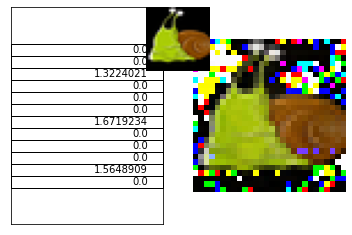

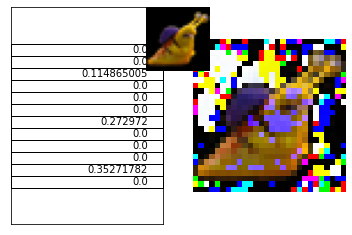

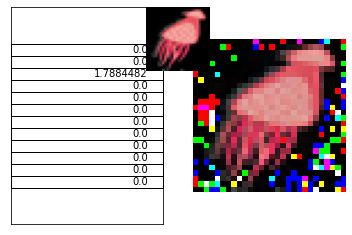

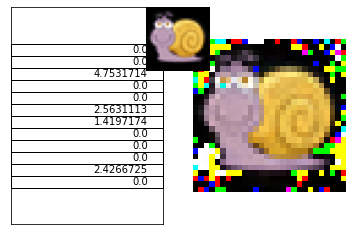

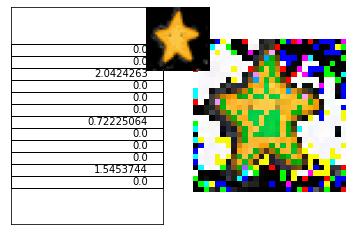

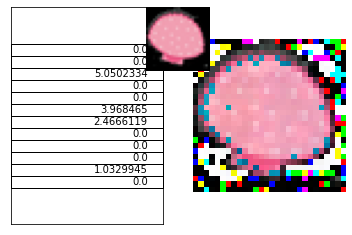

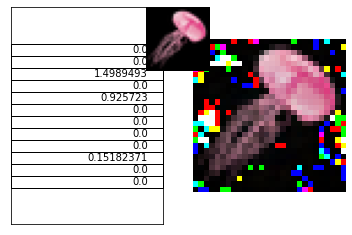

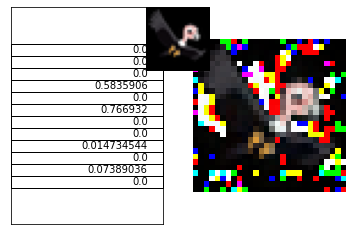

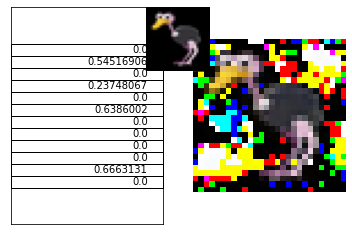

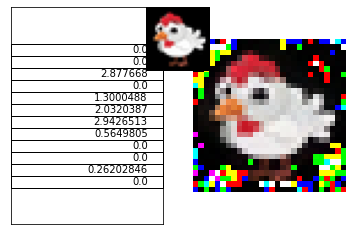

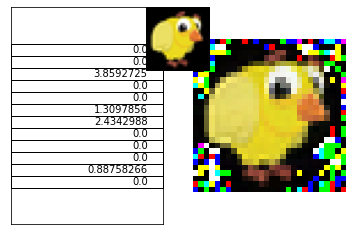

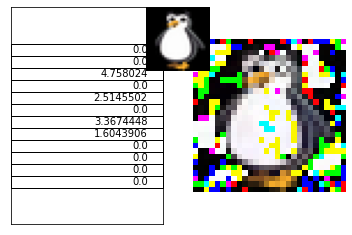

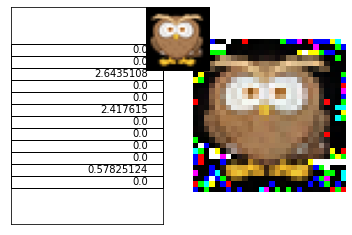

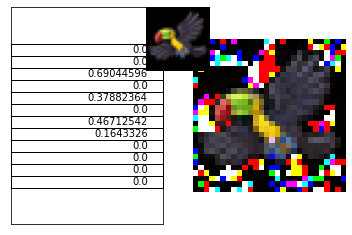

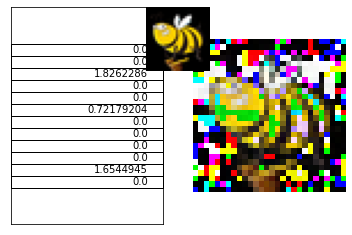

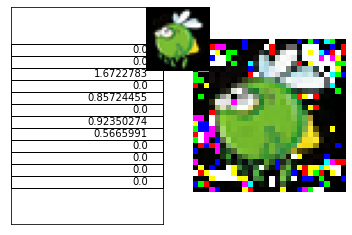

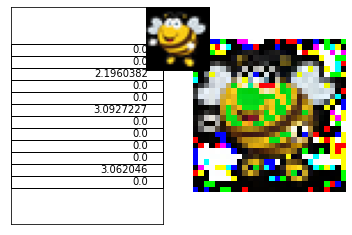

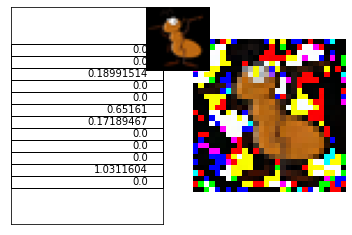

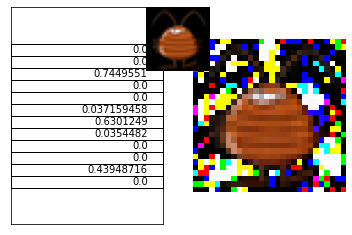

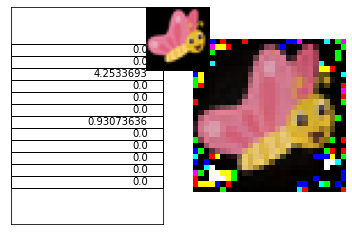

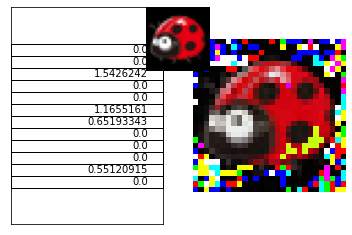

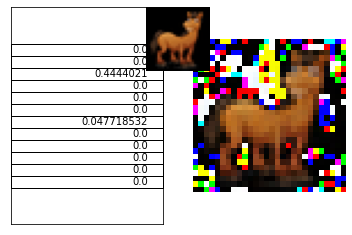

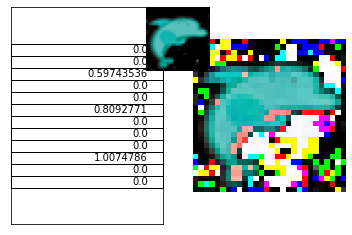

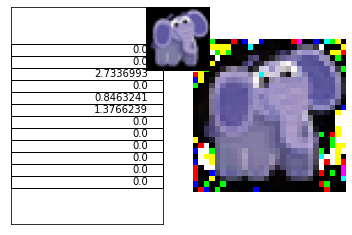

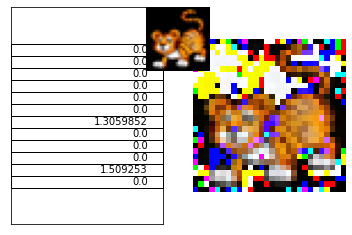

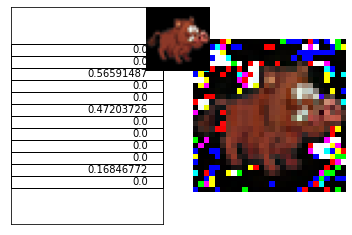

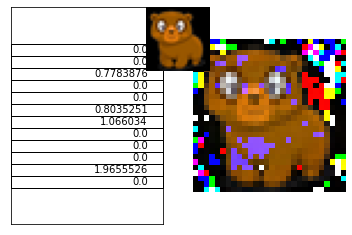

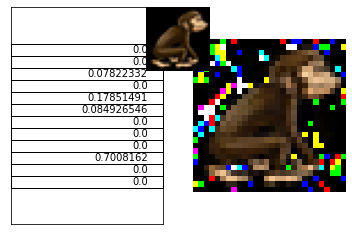

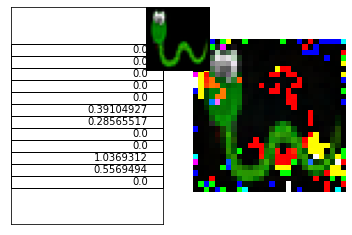

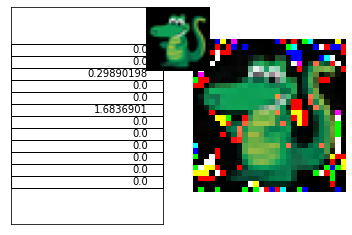

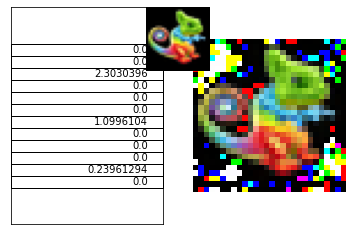

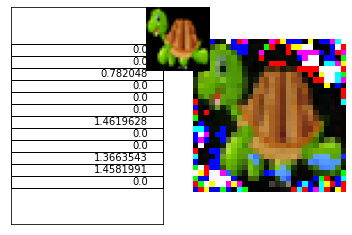

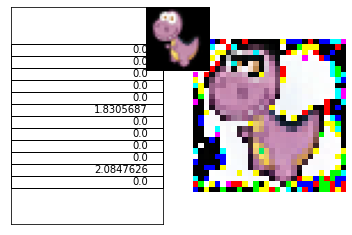

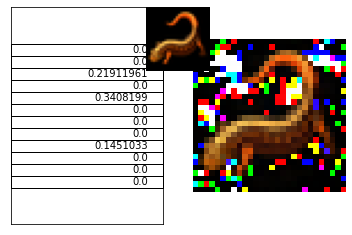

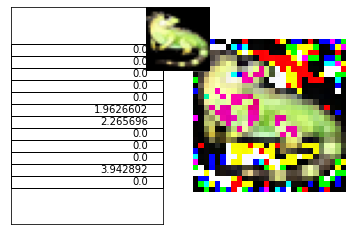

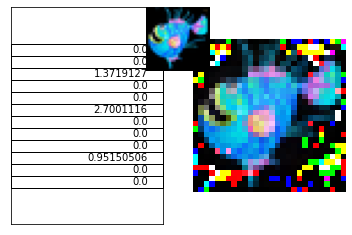

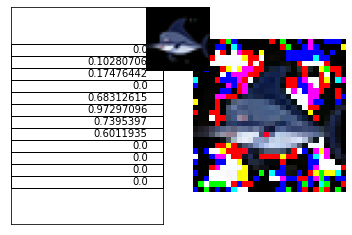

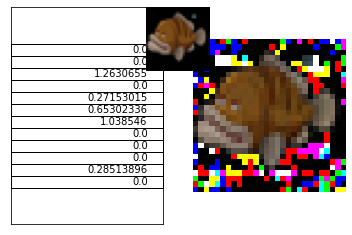

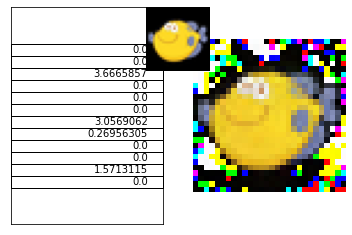

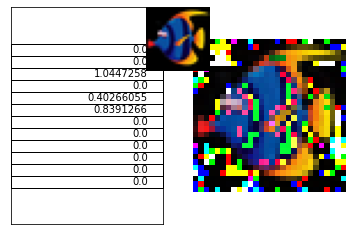

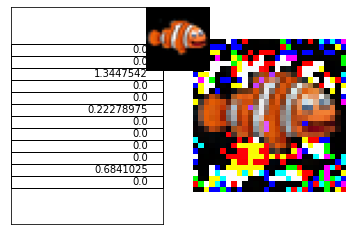

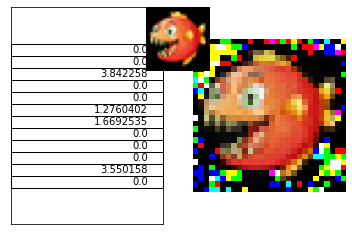

In [30]:
# prueba el modelo Generator usando como entrada los datos de Clustering
pruebaClust = CLUSTmodel.predict( x_train )
pruebaClust_out = GENmodel.predict(  np.array(pruebaClust).reshape((len(pruebaClust), num_features)) )  
 
# muestra las imágenes generadas
print("\n> Resultados (valores de clustering, imagen recounstrida(grande) y original(chica): ")
for i in range(len(x_train_encoded)):

    fig = plt.figure()

    # muestra los datos
    ax1 = fig.add_subplot(121)
    ax1.table(cellText=pruebaClust[i].reshape(num_features, 1), loc='center')   
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)  

    #  muestra reconstrucción
    ax2 = fig.add_subplot(122)
    plot_image(pruebaClust_out[i])  

    # muestra imagen original
    ax3 = fig.add_subplot(332)
    plot_image(x_train[i])  

    fig = plt.gcf()
